# Problem Set 1 Fergal Hanks

Notebook for problem set 1

In [1]:
import numpy as np
from scipy import stats
import markov_approx as ma
import matplotlib.pyplot as plt
import math as math
import scipy.special as special
import numba
%load_ext line_profiler

# Question 1
First I write a function to calculate the Variance and Kurtosis of a Distribution given a PDF. Then I write a function which works out and plots the variance of the distributions calculated for different size grids.

In [2]:
def stats_from_pdf(s,pi):
    """
    Gets variance and kurtosis of distribution from pdf
    """
    var =  pi.T@(s**2)-(pi.T@s)**2
    kurtosis = pi.T@((s-pi.T@s)**4/var**2)
    return var, kurtosis

In [3]:
def question_1(rho,N_grid,sigma_eps=1):
    """
    Plots the variance and kurtosis of the stationary distribution
    of Markov chain approximations to a AR(1) process against the true
    values for different grid sizes
    """
    #preallocate vectors for results
    Tauchen = np.zeros((2,np.size(N_grid)))
    Rouwenhorst = np.zeros((2,np.size(N_grid)))
    
    #loop over grid sizes
    #calculating statistics in each loop
    for i, N in enumerate(N_grid):
        ts, tpi, tPi = ma.tauchen(rho,sigma_eps,N=N)
        Tauchen[0,i],Tauchen[1,i] = stats_from_pdf(ts,tpi)
        rs, rpi, rPi = ma.rouwenhorst(rho,sigma_eps,N=N)
        Rouwenhorst[0,i],Rouwenhorst[1,i] = stats_from_pdf(rs,rpi)
    #True distribution statistics 
    real_dist = np.broadcast_to(np.array([[sigma_eps**2/(1-rho**2)],[(1-rho**2)**2*(1/(1-rho**4))*(6*rho**2*sigma_eps**8/(1-rho**2)+3*sigma_eps**8)]]),(2,len(N_grid)))
    
    #Create Plot
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(N_grid, Tauchen[0,:],label='Tauchen')
    ax1.plot(N_grid, Rouwenhorst[0,:],label='Rouwenhorst')
    ax1.plot(N_grid,real_dist[0,:],label='True Distribution')
    ax1.title.set_text('Variance')
    ax2.plot(N_grid, Tauchen[1,:],label='Tauchen')
    ax2.plot(N_grid, Rouwenhorst[1,:],label='Rouwenhorst')
    ax2.plot(N_grid,real_dist[1,:],label='True Distribution')
    ax2.title.set_text('Kurtosis')
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels,loc='upper center')
    
    return

The results are below

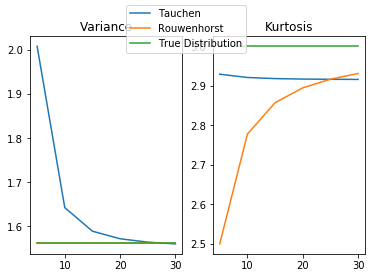

In [4]:
question_1(0.6,np.linspace(5,30,num=6,dtype=int))

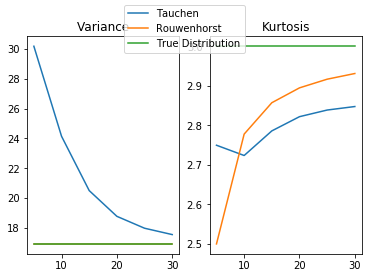

In [5]:
question_1(0.97,np.linspace(5,30,num=6,dtype=int))

# Question 2

Similarly I create a function which calculates the auto correlation for the markov chain distributions which I then call in a function that does the graphs

In [6]:
def auto_corr(s,pi,Pi):
    """
    Calculates the auto correlation from the transition matrix at the stationary distribution
    """
    var =  pi.T@(s**2)-(pi.T@s)**2
    #I could probably make this quicker by only calculating the diagonal
    cov = np.inner(pi,np.diag(Pi@np.outer(s,s)))
    return cov/var

In [34]:
def question_2(rho,N_grid,sigma_eps=1):
    """
    Loops over values in N_grid and calculates the auto correlation for the markov processes created
    by the Rouwenhorst and Tauchen methods. Then graphs these values against the true values
    """
    
    #preallocate vectors for results
    Tauchen = np.zeros(np.size(N_grid))
    Rouwenhorst = np.zeros(np.size(N_grid))
    
    #loop over grid sizes
    #calculating statistics in each loop
    for i, N in enumerate(N_grid):
        ts, tpi, tPi = ma.tauchen(rho,sigma_eps,N=N)
        Tauchen[i] = auto_corr(ts,tpi,tPi)
        rs, rpi, rPi = ma.rouwenhorst(rho,sigma_eps,N=N)
        Rouwenhorst[i] = auto_corr(rs,rpi,rPi)
    
    #Calculate statistics of the true distribution
    real_dist = np.full(np.size(N_grid),rho*sigma_eps**2)
    
    #Create Plot
    fig, ax =plt.subplots()
    ax.plot(N_grid, Tauchen,label='Tauchen')
    ax.plot(N_grid, Rouwenhorst,label='Rouwenhorst')
    ax.plot(N_grid,real_dist,label='True Distribution')
    ax.title.set_text('Auto correlation')
    ax.legend()
    return

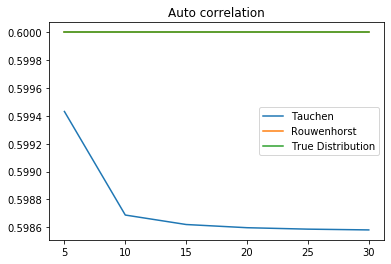

In [35]:
question_2(0.6,np.linspace(5,30,num=6,dtype=int))

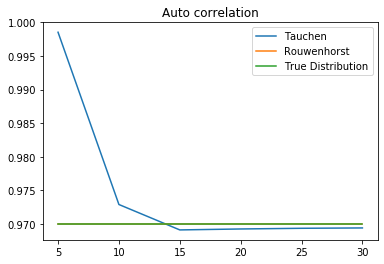

In [36]:
question_2(0.97,np.linspace(5,30,num=6,dtype=int))

# Question 3

Similarly I create a function which calculates the statistics for the innovations which I then call in a function that does the graphs

In [10]:
def innovation_stats(rho,s, pi, Pi):
    """
    Calculate the variance and kurtosis of the innovations
    """
    states = np.broadcast_to(s,(np.size(s),np.size(s)))
    var = np.inner(pi, np.diag(Pi@(states.T-rho*states)**2))
    kurtosis=np.inner(pi, np.diag(Pi@(states.T-rho*states)**4))/var**2
    return np.array([var,kurtosis])

In [11]:
def question_3(rho,N_grid,sigma_eps=1):
    """
    Plots the variance and kurtosis of the innovations
    of Markov chain approximations to a AR(1) process against the true
    values for different grid sizes
    """
    #preallocating arrays
    Tauchen = np.zeros((2,np.size(N_grid)))
    Rouwenhorst = np.zeros((2,np.size(N_grid)))
    
    #looping over N_grid values
    for i, N in enumerate(N_grid):
        ts, tpi, tPi = ma.tauchen(rho,sigma_eps,N=N)
        Tauchen[:,i] = innovation_stats(rho,ts, tpi, tPi)
        rs, rpi, rPi = ma.rouwenhorst(rho,sigma_eps,N=N)
        Rouwenhorst[:,i] = innovation_stats(rho,rs, rpi, rPi)
        
    #true values
    real_dist = np.broadcast_to(np.array([[sigma_eps**2],[0]]),(2,np.size(N_grid)))
    
    #creating plots
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(N_grid, Tauchen[0,:],label='Tauchen')
    ax1.plot(N_grid, Rouwenhorst[0,:],label='Rouwenhorst')
    ax1.plot(N_grid,real_dist[0,:],label='True Distribution')
    ax1.title.set_text('Variance')
    ax2.plot(N_grid, Tauchen[1,:],label='Tauchen')
    ax2.plot(N_grid, Rouwenhorst[1,:],label='Rouwenhorst')
    ax2.plot(N_grid,real_dist[1,:],label='True Distribution')
    ax2.title.set_text('Kurtosis')
    handles, labels = ax2.get_legend_handles_labels()
    fig.legend(handles, labels,loc='upper center')
    
    return

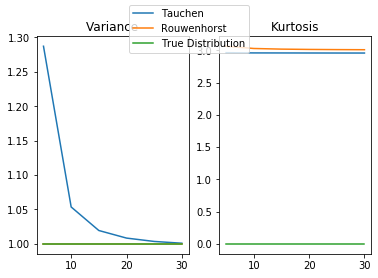

In [12]:
question_3(0.6,np.linspace(5,30,num=6,dtype=int))

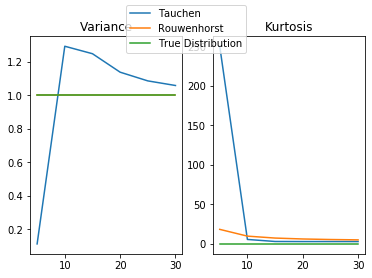

In [13]:
question_3(0.97,np.linspace(5,30,num=6,dtype=int))

# Question 4

There are several observations, the first is that the Rouwenhorst distribution gives a better approximation to an AR(1). This can be particularly seen in the variance exercises where rouwenhorst matches the variance exactly. The second main point is that the approimation is bad for higher order moments like Kurtosis which can be seen from the size of the errors in the kurtosis graphs. The third main point is that the more persistant the AR process the worse the approximation is. Finally the statistical properties of the innovations are different

# Question 5

In [14]:
%timeit ma.tauchen(0.6,1,N=20,m=3)

3.67 ms ± 40.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%timeit ma.rouwenhorst(0.6,1,N=20)

595 µs ± 4.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


As can be seen from the above results the tauchen function is almost 10 times slower than the rouwenhorst function

In [16]:
%lprun -f ma.tauchen ma.tauchen(0.6,1,N=20,m=3)

    Timer unit: 1e-07 s

    Total time: 0.0093027 s
    Function: tauchen at line 22
    Line #      Hits         Time  Per Hit   % Time  Line Contents
    ==============================================================

    46         1        198.0    198.0      0.2      sigma_s = sigma_eps/np.sqrt(1-rho**2)
    47                                           
    48                                               # discretized states and interval between them
    49         1       1308.0   1308.0      1.1      s = np.linspace(-sigma_s*m, sigma_s*m, N)
    50         1         23.0     23.0      0.0      ds = s[1] - s[0]
    51                                           
    52                                               # Tauchen method: probability of going from i to j is probability
    53                                               # that N(0, sigma_eps) innovation from s[i] ends up closer to s[j]
    54                                               # than to any other discretized state
    55         1         48.0     48.0      0.0      Pi = np.empty((N, N))
    56        19        347.0     18.3      0.3      for j in range(1, N - 1):
    57        18      54609.0   3033.8     46.9          Pi[:, j] = (norm.cdf(s[j] - rho*s + ds/2, scale=sigma_eps) -
    58        18      54616.0   3034.2     46.9                      norm.cdf(s[j] - rho*s - ds/2, scale=sigma_eps))
    59                                               
    60         1       2407.0   2407.0      2.1      Pi[:, 0] = norm.cdf(s[0] - rho*s + ds/2, scale=sigma_eps)
    61         1       2368.0   2368.0      2.0      Pi[:, -1] = 1 - norm.cdf(s[-1] - rho*s - ds/2, scale=sigma_eps)
    62                                               
    63         1        484.0    484.0      0.4      pi = stationary(Pi)
    64                                           
    65         1         11.0     11.0      0.0      return s, pi, Pi

Almost the entire time is spent on the loop constructing Pi so those are the obvious lines to attempt to optimise. What I do is to write out norm.cdf more explicitly using scipy.special.erf which potentially avoids some overhead from calling norm.cdf and allows me to do some cancelling of terms inside the loop. I can't use numba on the main loop as it doesn't support scipy functions

In [17]:
def fast_tauchen(rho, sigma_eps, N=7, m=3):
    """
    Faster version of the Tauchen function that uses the error function to calculate the CDF rather than calling
    scipy.stats.norm.cdf
    """
    # standard deviation of s_t
    sigma_s = sigma_eps/np.sqrt(1-rho**2)

    # discretized states and interval between them
    s = np.linspace(-sigma_s*m, sigma_s*m, N)
    ds = s[1] - s[0]

    # Tauchen method: probability of going from i to j is probability
    # that N(0, sigma_eps) innovation from s[i] ends up closer to s[j]
    # than to any other discretized state
    Pi = np.empty((N, N))
    for j in range(1, N - 1):
        Pi[:, j] = 0.5*(special.erf((s[j] - rho*s + ds/2)/(np.sqrt(2)*sigma_eps))-special.erf((s[j] - rho*s - ds/2)/(np.sqrt(2)*sigma_eps)))
    
    Pi[:, 0] = 0.5*(1+special.erf((s[0] - rho*s + ds/2)/(np.sqrt(2)*sigma_eps)))
    Pi[:, -1] = 1 - 0.5*(1+special.erf((s[-1] - rho*s - ds/2)/(np.sqrt(2)*sigma_eps)))
    pi = ma.stationary(Pi)

    return s, pi, Pi

In [18]:
%timeit fast_tauchen(0.6,1,N=20,m=3)

521 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
%lprun -f fast_tauchen fast_tauchen(0.6,1,N=20,m=3)

This speed is close to that of the Rouwenhorst function meaning I have acheived a speedup of almost 10 times. This speedup can be seen when using lprun as the inner loop now takes only around 60% of the runtime rather than over 90% before. Below I check that the function is working correctly by comparing the results to the original tauchen function.

In [20]:
fast_s,fast_pi,fast_Pi = fast_tauchen(0.6,1,N=20,m=3)
slow_s, slow_pi, slow_Pi = ma.tauchen(0.6,1,N=20,m=3)
np.allclose(slow_Pi,fast_Pi)

True

Then I optimise the Rouwenhorst function. The obvious thing to do here is to extract the recursive loop into a seperate function which can then be compiled using numba. Additionally I add an additional loop rather than using broadcasting, this made the function around 2 times faster

In [21]:
@numba.njit
def fast_recursion(N,p,Pi_initial):
    """
    Function containing the recursion in the Rouwenhorst method. Complied using numba for speed.
    Breaks down the vectorised components of the original function to increase speed.
    """
    Pi = Pi_initial
    #recursion that builds from n=3 to n=N
    for n in range(3,N+1):
        Pi_old = Pi
        Pi = np.zeros((n, n))
        for i in range(n-1):
            for j in range(n-1):
                Pi[i, j] += p * Pi_old[i, j]
                Pi[i, j+1] += (1 - p) * Pi_old[i, j]
                Pi[i+1, j] += (1 - p) * Pi_old[i, j]
                Pi[i+1, j+1] += p * Pi_old[i, j]
        for i in range(n-2):
            for j in range(n):
                Pi[i+1, j] /= 2
    return Pi

def fast_rouwenhorst(rho, sigma_eps, N=7):
    """
    Faster function to generate Rouwenhorst approximation to an AR(1)
    """
    # parametrize Rouwenhorst Markov matrix for n=2
    p = (1 + rho) / 2
    Pi = np.array([[p, 1 - p], [1 - p, p]])

    # implement recursion to build from n=3 to n=N
    Pi = fast_recursion(N,p,Pi)
        
    pi = ma.stationary(Pi)

    # analytically determined spacing of points should give exactly right sd
    psi = sigma_eps / np.sqrt(1 - rho**2) * np.sqrt(N - 1)
    s = np.linspace(-psi, psi, N)

    return s, pi, Pi

In [22]:
%timeit fast_rouwenhorst(0.6,1,N=20)

106 µs ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is around a 5 times speedup. I check that the function is working correctly below

In [23]:
fast_s,fast_pi,fast_Pi = fast_rouwenhorst(0.6,1,N=20)
slow_s, slow_pi, slow_Pi = ma.rouwenhorst(0.6,1,N=20)
np.allclose(slow_Pi,fast_Pi)

True

Overall this optimisation is unlikely to be worth it in most applications for two reasons. The first is that in many typical applications these functions will only be called once to generate the transition matrix and stationary distribution and then those objects will get used repeatedly in steps like iterating to find the policy function of the household. Therefore since it will only be called once compiling it may not even lead to an actual speedup once the time cost of compilation is taken into account. Secondly even if the function is called repeatedly say when trying to find the likelihood of the persistance parameter the majority of the time of the program will be spent on other steps like policy function iteration which are more expensive so time is better spent optimising those sections of code.

There is however one arguement for optimising this section of code and that is the applicability of this function across projects so by optimising it once you can improve the efficiency of many projects

# Question 6

The first step is to construct the MC alogrithm to approximate the transition matrix

In [24]:
@numba.njit
def mc_steps(p,steps,processes,draws):
    """
    Function that given the draws calculates what happens to independent 0-1 processes and then sums up the result.
    calulates both the transition probabilities and stationary distribution of the sum of the processes
    Complied using numba for speed
    """
    #preallocating arrays
    process = np.zeros(processes)
    last_value = 0
    Pi = np.zeros((processes+1,processes+1))
    totals = np.zeros(processes+1)
    
    #Steps of MC algorithm
    #in each step check the draws to see which processes transition
    #Then calculate what happens to the sum of these processes and record the transitions
    for n in range(steps):
        for i in range(processes):
            process[i] += draws[n, i]*(( process[i]==0)-1*(process[i]==1))
        value = np.sum(process)
        totals[int(value)] += 1
        Pi[int(last_value), int(value)] +=1
        last_value = value
        
    #divide array of transitions by times in a state to get transition matrix
    for i in range(processes+1):
        Pi[i,:] /=totals[i]
    return totals/steps, Pi 


def monte_carlo(p,steps,processes):
    """
    Function that calls the inner loop of the monte carlo simulation
    """
    stationary_dist, Pi = mc_steps(p,steps,processes,np.random.binomial(1,1-p,size=(steps,processes)))
    return stationary_dist, Pi



In [25]:
%timeit monte_carlo(0.9,1000000,3)

87.7 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
mc_pi,mc_Pi = monte_carlo(0.9,1000000,3)
print(mc_pi)
print(mc_Pi)

[0.12499  0.3739   0.375804 0.125306]
[[0.7299704  0.24211537 0.02682615 0.00109609]
 [0.08103236 0.74711688 0.1627494  0.00910136]
 [0.00882641 0.16194878 0.74802557 0.08119658]
 [0.00108534 0.02737299 0.24330838 0.72823328]]


In [27]:
rs, rpi, rPi = fast_rouwenhorst(0.8,1,N=4)
print(rpi)
print(rPi)

[0.125 0.375 0.375 0.125]
[[0.729 0.243 0.027 0.001]
 [0.081 0.747 0.163 0.009]
 [0.009 0.163 0.747 0.081]
 [0.001 0.027 0.243 0.729]]


Both the stationary distribution and the transition matrix from the simulation are very similar to that of the recursion that is calculated by the rouwenhorst function.